# Importing data from drive


In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1oMX4s7NGtYBTh0gUHzXuloZT1rp5Shpq"})   
downloaded.GetContentFile('DataSet.zip')           

In [ ]:
from zipfile import ZipFile

with ZipFile("DataSet.zip", 'r') as file:
    file.extractall()
file.close()

In [ ]:
VAL_LOC = "/content/DataSet/Testing_Unmasked"
TRAIN_LOC = "/content/DataSet/Training"
MASKED_LOC = "/content/DataSet/Testing_masked"

# Installing LiveLossPlot

In [ ]:
!pip install livelossplot

# Importing Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Embedding, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from livelossplot import PlotLossesKeras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

import os
from PIL import Image
import cv2
from collections import Counter
import imutils
from imutils import paths

from scipy.spatial.distance import cosine, euclidean
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Loading our data

In [ ]:
train_data = TRAIN_LOC
val_data = VAL_LOC
masked_data = MASKED_LOC

In [ ]:
train_names = []; val_names = []; masked_names = []
train_names_count = []; val_names_count = []; masked_names_count = []

for class_ in os.listdir(train_data):
    train_names.append(class_)
    train_names_count.append(len(os.listdir(os.path.join(train_data, class_))))

for class_ in os.listdir(val_data):
    val_names.append(class_)
    val_names_count.append(len(os.listdir(os.path.join(val_data, class_))))

for class_ in os.listdir(masked_data):
    masked_names.append(class_)
    masked_names_count.append(len(os.listdir(os.path.join(masked_data, class_))))

In [ ]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Bar(name='training', x=train_names, y=train_names_count), row = 1, col = 1)
fig.add_trace(go.Bar(name='validation', x=val_names, y=val_names_count), row = 1, col = 2)
fig.add_trace(go.Bar(name='masked', x=masked_names, y=masked_names_count), row = 1, col = 3)

fig.update_layout(title_text="Data", title_x = 0.5)
fig.show(renderer="colab")

In [ ]:
num_classes = len(glob(train_data+"/*"))
num_classes

4

# Using AUTO_ENCODER

## Building auto_encoder

In [ ]:
class Autoencoder:
    
    @staticmethod
    def create(embedding_dim = 1024):
        """
        Here, we are defining our encoder where:
            Input Image size : (150, 150, 3)
            Embedding_dim : 1024 (default)

        """
        input_img = tf.keras.Input(shape=(150, 150, 3))
        encoded = Conv2D(32, (3, 3), activation='relu', padding='same', name = "layer_0")(input_img)
        encoded = MaxPooling2D((2, 2), padding='same', name = "layer_1")(encoded)
        encoded = Conv2D(16, (3, 3), activation='relu', padding='same', name = "layer_2")(encoded)     
        encoded_flat = Flatten()(encoded) 
        embedding = Dense(embedding_dim, activation = "relu", name = "embedding")(encoded_flat)
        encoder = tf.keras.Model(input_img, embedding, name = "encoder")

        volShape = K.int_shape(encoded)

        """
        Here, we are defining our decoder

        """
        flat_layer = Dense(K.int_shape(encoded_flat)[1])(embedding)
        reshaped_encod = Reshape((volShape[1],volShape[2], volShape[3]))(flat_layer)
        decoded = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', name = "layer_3")(reshaped_encod)
        decoded = UpSampling2D((2, 2), name = "layer_4")(decoded)
        decoded = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', name = "layer_5")(decoded)
        outputs = tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name = "layer_6")(decoded)

        # decoder = tf.keras.Model(embeddingInputs, outputs)

        autoencoder = tf.keras.Model(input_img, outputs)

        return (encoder, autoencoder)

In [ ]:
encoder, autoencoder = Autoencoder.create()

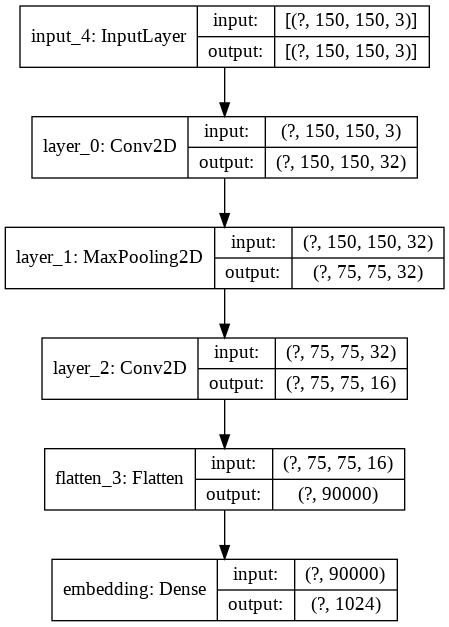

In [ ]:
plot_model(encoder, to_file='Encoder.png', show_shapes=True, show_layer_names=True)

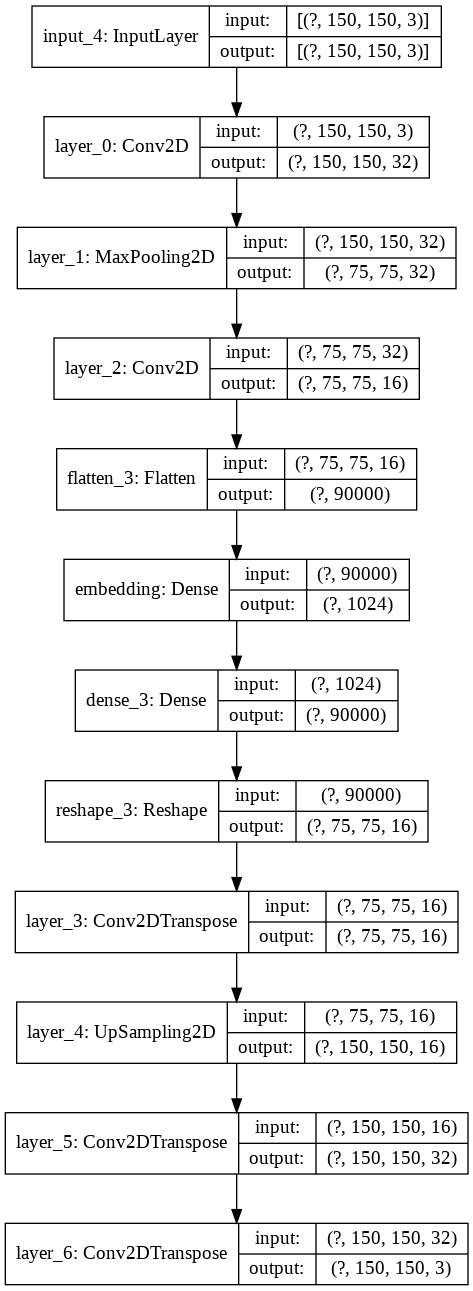

In [ ]:
plot_model(autoencoder, to_file='AutoEncoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
layer_0 (Conv2D)             (None, 150, 150, 32)      896       
_________________________________________________________________
layer_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
_________________________________________________________________
layer_2 (Conv2D)             (None, 75, 75, 16)        4624      
_________________________________________________________________
flatten_3 (Flatten)          (None, 90000)             0         
_________________________________________________________________
embedding (Dense)            (None, 1024)              92161024  
_________________________________________________________________
dense_3 (Dense)              (None, 90000)            

## Creating different sets of ImageS

In [ ]:
def build_data(img_folder_path, normalize = True):
    label = img_folder_path.split("/")[-1]
    images = []
    img_paths = list(imutils.paths.list_images(img_folder_path))
    for img_path in img_paths:
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if normalize:
            image = image.astype('float32') / 255.
        image = cv2.resize(image, (150, 150))

        images.append(image)
    images = np.array(images)
    return images, label

In [ ]:
rudra_train_img_path = "/content/DataSet/Training/Rudra"
rudra_unmasked_img_path = "/content/DataSet/Testing_Unmasked/Rudra"
rudra_masked_img_path = "/content/DataSet/Testing_masked/Rudra"

Aayush_train_img_path = "/content/DataSet/Training/Aayush"
Aayush_unmasked_img_path = "/content/DataSet/Testing_Unmasked/Aayush"
Aayush_masked_img_path = "/content/DataSet/Testing_masked/Aayush"

AshishM_train_img_path = "/content/DataSet/Training/AshishM"
AshishM_unmasked_img_path = "/content/DataSet/Testing_Unmasked/AshishM"
AshishM_masked_img_path = "/content/DataSet/Testing_masked/AshishM"

Komal_train_img_path = "/content/DataSet/Training/Komal"
Komal_unmasked_img_path = "/content/DataSet/Testing_Unmasked/Komal"
Komal_masked_img_path = "/content/DataSet/Testing_masked/Komal"

In [ ]:
rudra_train, _ = build_data(rudra_train_img_path)
rudra_val, _ = build_data(rudra_unmasked_img_path)
rudra_masked, _ = build_data(rudra_masked_img_path)

print(f"Shape of rudra_train : {rudra_train.shape}")
print(f"Shape of rudra_val : {rudra_val.shape}")
print(f"Shape of rudra_masked : {rudra_masked.shape}")

Shape of rudra_train : (518, 150, 150, 3)
Shape of rudra_val : (208, 150, 150, 3)
Shape of rudra_masked : (56, 150, 150, 3)


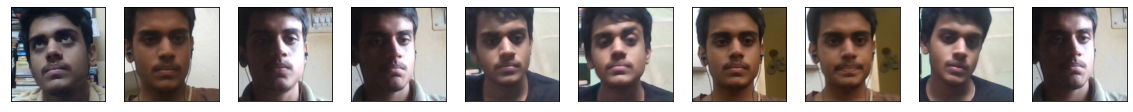

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(rudra_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Training

In [ ]:
liveplot = PlotLossesKeras()
BS = 32

autoencoder.compile(loss = 'mse', optimizer = 'adam')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience = 10, min_lr = 2e-5, mode = 'min')

callbacks = [liveplot, reduce_lr]

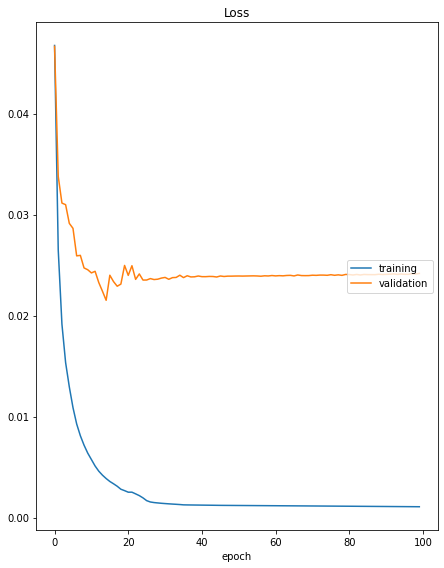

Loss
	training         	 (min:    0.001, max:    0.047, cur:    0.001)
	validation       	 (min:    0.022, max:    0.047, cur:    0.024)
17/17 [==============================] - 2s 100ms/step - loss: 0.0011 - val_loss: 0.0242


In [ ]:
training_history = autoencoder.fit(rudra_train, 
                                   rudra_train,
                                   validation_data = (rudra_val, rudra_val),
                                   epochs = 100,
                                   verbose = 1,
                                   batch_size = BS,
                                   shuffle = True,
                                   callbacks = callbacks)

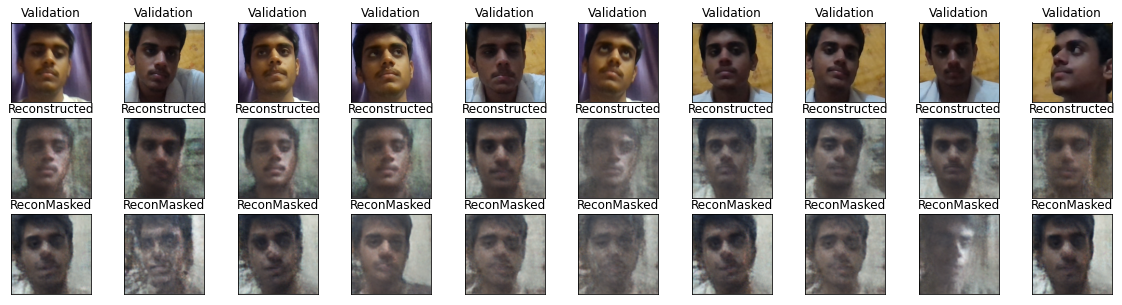

In [ ]:
decoded_imgs = autoencoder.predict(rudra_val)
decoded_masked_imgs = autoencoder.predict(rudra_masked)

n = 10
plt.figure(figsize=(20, 5))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(rudra_val[10+i]);
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Validation")    

    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[10+i]);
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Reconstructed")

    # Display masked reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_masked_imgs[10+i]);
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("ReconMasked")

plt.show();

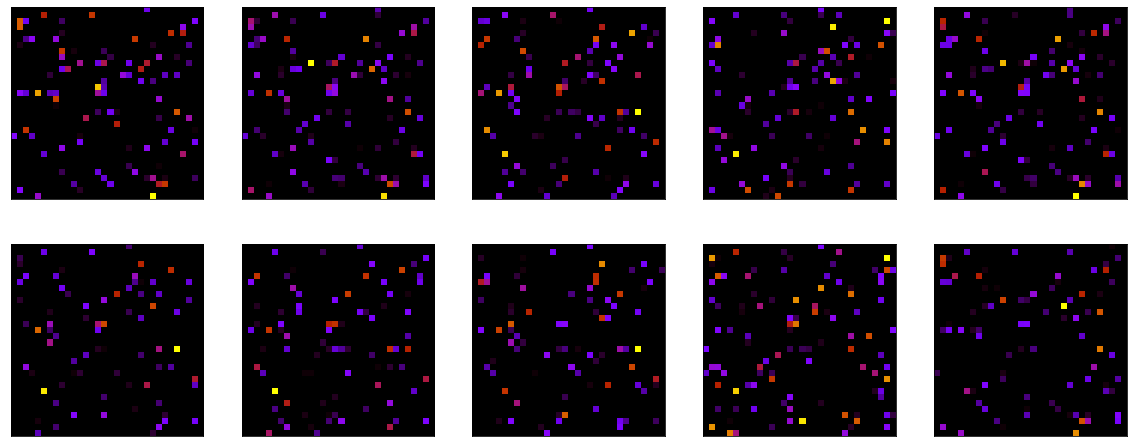

In [ ]:
encoded_imgs = encoder.predict(rudra_val)

#shape of encodede_imgs : (50, 125, 125, 16)
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(2, 5, i)
    plt.imshow(encoded_imgs[i].reshape(32, 32), cmap = 'gnuplot')
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show();

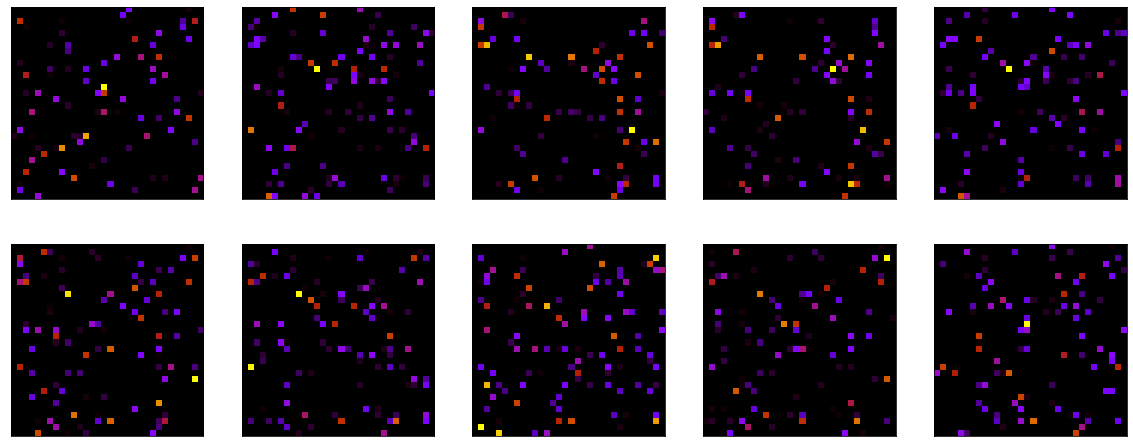

In [ ]:
encoded_masked_imgs = encoder.predict(rudra_masked)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(2, 5, i)
    plt.imshow(encoded_masked_imgs[i].reshape(32, 32), cmap = 'gnuplot')
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show();

In [ ]:
list(encoded_imgs[1])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.70817155,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.8581848,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.2258837,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.009772209,
 0.0,
 0.0,
 0.0,
 2.663976,
 0.753542,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.24690315,
 0.0,
 0.009018988,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9464927,
 0.0,
 0.0,
 2.6695175,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1678054,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.08749002,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

In [ ]:
list(encoded_masked_imgs[1])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9586836,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.03730757,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.7556627,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0469728,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01662909,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.014761704,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.39908573,
 0.0,
 1.7803481,
 0.0,
 0.0,
 0.0,
 0.025930317,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6538674,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.12556781,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1660391,
 0

## Checking Accuracy : 


### metric : cosine similarity

In [ ]:
base_encode = encoded_imgs[1]

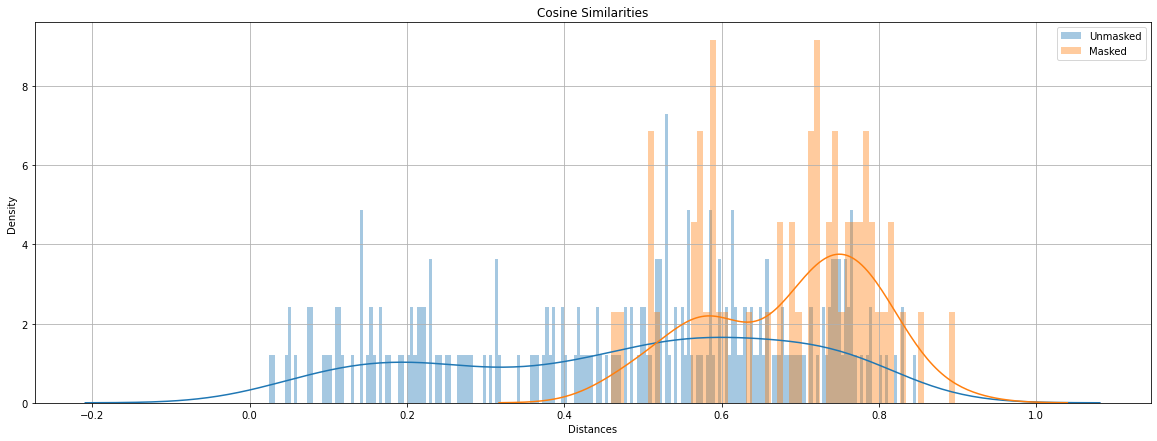

In [ ]:
similarities_unmasked = []
similarities_masked = []

for encode_img in encoded_imgs[2:]:
    similarities_unmasked.append(cosine(encode_img, base_encode))

for encode_maskedimg in encoded_masked_imgs:
    similarities_masked.append(cosine(encode_maskedimg, base_encode))

plt.figure(figsize = (20, 7))
sns.distplot(similarities_unmasked, bins = len(similarities_unmasked), label="Unmasked")
sns.distplot(similarities_masked, bins = len(similarities_masked), label = "Masked")

plt.xlabel("Distances")
plt.grid(True)
plt.legend()
plt.title("Cosine Similarities")
plt.show();

In [ ]:
THRES = 0.5
similarities_unmasked = list(map(lambda x: 1 if x<=THRES else 0, similarities_unmasked))
similarities_masked = list(map(lambda x: 1 if x<=THRES else 0, similarities_masked))

print(f"Accuracy in unmasked_images : {round(sum(similarities_unmasked)*100/len(similarities_unmasked), 3)}")
print(f"Accuracy in masked_images : {round(sum(similarities_masked)*100/len(similarities_masked), 3)}")

Accuracy in unmasked_images : 46.117
Accuracy in masked_images : 3.571


## metric : dist

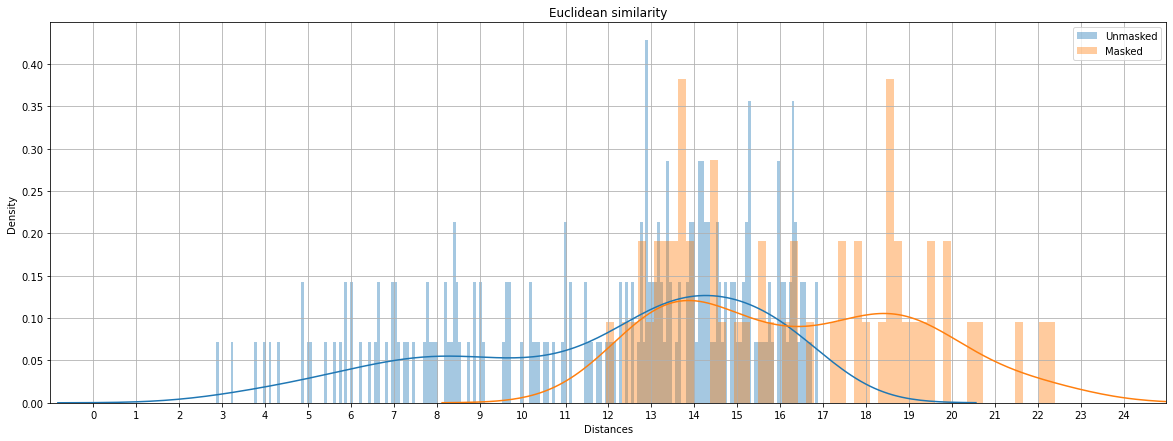

In [ ]:
similarities_unmasked = []
similarities_masked = []

for encode_img in encoded_imgs[2:]:
    similarities_unmasked.append(euclidean(encode_img, base_encode))

for encode_maskedimg in encoded_masked_imgs:
    similarities_masked.append(euclidean(encode_maskedimg, base_encode))

plt.figure(figsize = (20, 7))
sns.distplot(similarities_unmasked, bins = len(similarities_unmasked), label="Unmasked")
sns.distplot(similarities_masked, bins = len(similarities_masked), label = "Masked")

plt.xlabel("Distances")
plt.grid(True)
plt.xticks([i for i in range(0, 25)])
plt.legend()
plt.xlim((-1, 25))
plt.title("Euclidean similarity")

plt.show();

In [ ]:
THRES = 17
similarities_unmasked = list(map(lambda x: 1 if x<=THRES else 0, similarities_unmasked))
similarities_masked = list(map(lambda x: 1 if x<=THRES else 0, similarities_masked))

print(f"Accuracy in unmasked_images : {round(sum(similarities_unmasked)*100/len(similarities_unmasked), 3)}")
print(f"Accuracy in masked_images : {round(sum(similarities_masked)*100/len(similarities_masked), 3)}")

Accuracy in unmasked_images : 100.0
Accuracy in masked_images : 55.357
